In [2]:
import pytorch_lightning as pl

/home/marek/.cache/pypoetry/virtualenvs/dp-IF5g67NU-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dataset import *
import random
import numpy as np
from tqdm import tqdm
import multiprocessing
from scipy.stats import wasserstein_distance
from statistics import mean
import pickle
import matplotlib.pyplot as plt

In [3]:
K=12
m=24

In [4]:
ds = IrisVerificationDatasetPseudo('../../Datasets/', 1, subsets=[
    'train_iris_casia_v4', 'train_iris_nd_0405', 
    'train_iris_nd_crosssensor_2013', 'train_iris_utris_v1'
])

In [5]:
image_ids= np.arange(len(ds.annotations), dtype=np.int32)
image_classes = np.zeros(len(ds.annotations), dtype=np.int32)
image_ids_string = np.array([a['__image_id'] for a in ds.annotations])

for image_idx, annotation in enumerate(ds.annotations):
    image_classes[image_idx] = annotation['__class_number']

In [6]:
permute_dict = {} #image id: (pairs: samples of pairs, impostros: samples of impostors)
for image_idx in tqdm(image_ids, "Generating random pairs and impostors:"):
    image_cls = image_classes[image_idx]
    image_id_str = image_ids_string[image_idx]

    image_ids_pair = image_ids[np.logical_and(image_classes == image_cls, image_ids != image_idx)]
    image_ids_impostor = image_ids[image_classes != image_cls]

    permute_dict[image_id_str] = (
        tuple(image_ids_string[np.random.choice(image_ids_pair, m*K)].tolist()),
        tuple(image_ids_string[np.random.choice(image_ids_impostor, m*K)].tolist()),
    )

Generating random pairs and impostors:: 100%|██████████| 170280/170280 [03:55<00:00, 722.48it/s]


In [21]:
rand_vec = {}
run_name="RecognitionNet-mobilenetv3_large-MagFaceLoss-GOTTXb"
with open(f'../runs_mnt/{run_name}/embedding-{run_name}-iris_verification_iitd_01_01.pickle', 'rb') as f:
    rand_vec = pickle.load(f)

In [22]:
rand_vec[2].shape

(512,)

In [16]:
list(rand_vec.keys())[0]

1

In [8]:
batch_size=32
vec_dim=512

vector_batch = np.zeros((len(rand_vec), vec_dim))
idx_to_id = {}
id_to_idx = {}

for idx, img in enumerate(rand_vec):
    id_to_idx[img] = idx
    idx_to_id[idx] = img
    vector_batch[idx] = rand_vec[img]

vector_len = np.linalg.norm(vector_batch, axis=1)
one_over_vector_len = 1/vector_len
distances_v = np.zeros((len(permute_dict), K*m*2, 1))

In [9]:

for start_id in tqdm(range(0,len(permute_dict),batch_size), "Calculating cosine distances"):#len(permute_dict)

    root_vectors = vector_batch[start_id:start_id+batch_size, :, np.newaxis]
    root_one_over = one_over_vector_len[start_id:start_id+batch_size, np.newaxis, np.newaxis]
    batch_vectors = np.zeros((batch_size, K*m*2, vec_dim))
    batch_one_over = np.zeros((batch_size, K*m*2, 1))

    for i in range(start_id, min(start_id+batch_size, len(permute_dict))):
        pair, impostor = permute_dict[idx_to_id[i]]
        idxs = np.array(
            [id_to_idx[p] for p in pair ] + [id_to_idx[i] for i in impostor], 
            dtype=np.int32
        )
        batch_vectors[i-start_id, :, :] = vector_batch[idxs]
        batch_one_over[i-start_id, :, :] = one_over_vector_len[idxs, np.newaxis]
        
        
    distances_v[start_id:start_id+batch_size, :] = ((batch_vectors @ root_vectors) * batch_one_over * root_one_over)

Calculating cosine distances: 100%|█████████▉| 5321/5322 [12:35<00:00,  7.04it/s]


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (32,576,512)->(32,newaxis,newaxis) (8,512,1)->(8,newaxis,newaxis)  and requested shape (576,1)

In [ ]:
q = {}
for idx in tqdm(range(len(permute_dict)), "Calculating wasserstein distances"):
    w_distance = 0
    image_id=idx_to_id[idx]
    for i in range(0, K*m, m):
        p = distances_v[idx][i:i+m][0]
        n = distances_v[idx][K*m+i:K*m+i+m][0]
        w_distance += wasserstein_distance(p, n)
    w_distance = w_distance/K
    q[image_id] = w_distance

Calculating wasserstein distances: 100%|██████████| 170280/170280 [02:03<00:00, 1383.71it/s]


In [ ]:
with open(f"../runs/{run_name}/pseudolabels-{run_name}.pickle", "wb") as f:
    pickle.dump(q, f)

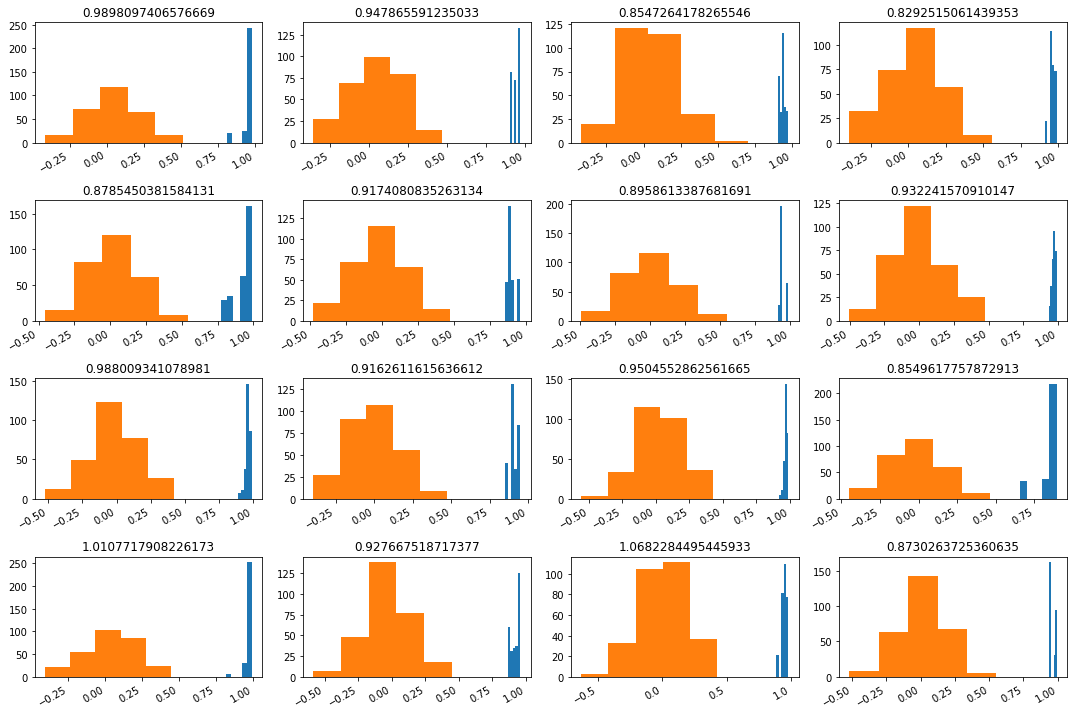

In [ ]:
smp=random.sample(list(range(512)), 16)

fig, axs = plt.subplots(4, 4, figsize=(15,10))

for j, ind in enumerate(smp):
    w_distance = q[idx_to_id[ind]]
    axs[j//4][j%4].title.set_text(str(w_distance))
    axs[j//4][j%4].hist(distances_v[ind][:K*m], 5)
    axs[j//4][j%4].hist(distances_v[ind][K*m:], 5)
    plt.setp(axs[j//4][j%4].get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.show()

In [10]:
m = 100
m_id = ""
for k in q:
    if m > q[k]:
        m = q[k]
        m_id = k

NameError: name 'q' is not defined